# Data Modelling

In this notebook we will be going through the data modelling process. We will train a few different models on the dataset and evaluate them. We will then select the best performing model to carry out our predictions on. Lastly, we will look into the performance of our selected model.

## 1. Imports and Setup

### 1.1 Software imports

In [136]:
import pandas as pd
import numpy as np
import random

import os
import glob
import pathlib

import PIL.Image as Image
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.python.keras.layers import (Input, Conv2D, MaxPooling2D, 
GlobalAveragePooling2D, Dropout, Flatten, Dense)

from tensorflow import keras
from keras.engine import Model
from keras.layers import Input

from tensorflow.python.keras.preprocessing import image
from tensorflow.python.keras.models import Model, load_model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, Callback

from sklearn.metrics import accuracy_score, mean_absolute_error
from sklearn.model_selection import train_test_split

In [2]:
font = {'family' : 'sans-serif',
        'weight' : 'regular',
        'size'   : 12}

plt.rc('font', **font)

### 1.2 Data Imports

As this model training is quite computationally taxing, we carried it out using Google Collab. If you are running this on a computer with a GPU, you might be able to run it efficiently; otherwise we recommend running this notebook on Colab as well.

The image data is stored as an archive TAR file on Dropbox. The file is shared for public access so the code below should run without any problem.

Since we carried out our data modelling on Google Colab, other file imports/exports are done by [mounting our Google Drive](https://colab.research.google.com/notebooks/io.ipynb) into the notebook. You may use that method as well, but if you are running on your local machine, please do adjust the data import/export code accordingly!

In [3]:
dataset_url = "https://www.dropbox.com/s/bdjm481gidafusd/UTKFace.tar?dl=1"

In [4]:
data_dir = tf.keras.utils.get_file(origin=dataset_url, 
                                   fname='UTKFace', 
                                   untar=True)
data_dir = pathlib.Path(data_dir)

138215424/138209280 [==============================] - 1s 0us/step


In [5]:
data_dir

#this is the directory where the images files have been extracted and stored

PosixPath('/root/.keras/datasets/UTKFace')

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
filepath = '/content/drive/My Drive/DSI Projects/Capstone Project/'

In [8]:
face_data = pd.read_csv(filepath + 'Data/age_gender_filtered.csv')

#this is the CSV we exported at the end of our Exploratory Analysis

In [9]:
face_data.head()

,age,ethnicity,gender,age group,Filename,age label
0,1,2,0,Baby,1_0_2_20161219203650636.jpg.chip.jpg,0
1,1,2,0,Baby,1_0_2_20161219222752047.jpg.chip.jpg,0
2,1,2,0,Baby,1_0_2_20161219222832191.jpg.chip.jpg,0
3,1,2,0,Baby,1_0_2_20161220144911423.jpg.chip.jpg,0
4,1,2,0,Baby,1_0_2_20161220144914327.jpg.chip.jpg,0


In [10]:
face_data.shape

(13356, 6)

### 1.3 Create Image Dataset

In [11]:
X = face_data
y = face_data['age label']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 42)
#stratify y to maintain the proportion of age groups in the training/testing data

In [13]:
y_train.value_counts(normalize = True)

6    0.196466
5    0.180294
7    0.151742
8    0.103424
0    0.080363
9    0.072676
2    0.067585
1    0.057702
4    0.056204
3    0.033543
Name: age label, dtype: float64

In [14]:
y_test.value_counts(normalize = True)

6    0.196466
5    0.180294
7    0.151842
8    0.103324
0    0.080264
9    0.072776
2    0.067385
1    0.057802
4    0.056304
3    0.033543
Name: age label, dtype: float64

In [15]:
len(y_test)

3339

In [16]:
len(y_train)

10017

In [17]:
data_dir

PosixPath('/root/.keras/datasets/UTKFace')

In [18]:
X_train['Filename'].head()

10622    48_1_1_20170113001756978.jpg.chip.jpg
10896    50_1_0_20170113210319697.jpg.chip.jpg
7227     30_1_3_20170117144459082.jpg.chip.jpg
7412     30_0_3_20170119195819708.jpg.chip.jpg
11654    56_0_0_20170120222907250.jpg.chip.jpg
Name: Filename, dtype: object

In [19]:
train_filenames = []

for file in X_train['Filename']:
    
    name = str(data_dir) + '/' + file
    
    train_filenames.append(name)
    
len(train_filenames)

10017

In [20]:
train_filenames[:2]

['/root/.keras/datasets/UTKFace/48_1_1_20170113001756978.jpg.chip.jpg',
 '/root/.keras/datasets/UTKFace/50_1_0_20170113210319697.jpg.chip.jpg']

**Creating Tensor Slices, Dataset**

We will be creating the image dataset from [Tensor Slices](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#from_tensor_slices). There are other methods of creating a Tensorflow Dataset, but we selected this as it gives us finer control of the dataset.

In [21]:
def _parse_function(filename, label):
    image_string = tf.io.read_file(filename)
    image_decoded = tf.image.decode_jpeg(image_string,channels=3)
    image_resized = tf.image.resize(image_decoded, [224, 224])
    label = tf.one_hot(label, 10)
    return image_resized, label

# this function will read an image file and preprocess it accordingly
# it will also do a one-hot encoding for the labels given

In [22]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_filenames, y_train))
train_dataset = train_dataset.map(_parse_function)
train_dataset = train_dataset.batch(32)

#we create the dataset based on the filenames in X_train

In [23]:
len(X_test['Filename'])

3339

In [24]:
test_filenames = []

for file in X_test['Filename']:
    
    name = str(data_dir) + '/' + file
    
    test_filenames.append(name)
    
len(test_filenames)

3339

In [25]:
validation_dataset = tf.data.Dataset.from_tensor_slices((test_filenames, y_test))
validation_dataset = validation_dataset.map(_parse_function)
validation_dataset = validation_dataset.batch(32)

### 1.3 Inspecting Image Dataset

In [26]:
age_groups = ['Baby', 'Toddler', 'Child', 'Adolescent', 'Teenager',
              'Young Adult', 'Adult', 'Mature Adult', 'Middle Age', 'Senior']

In [27]:
len(age_groups)

10

In [28]:
for images, labels in train_dataset.take(1):
    print(labels[1])
    print(np.argmax(labels[1]))
    print(age_groups[np.argmax(labels[1])])
    
#this is to show how the predictions/labels look like, 
#and how we can retrieve the age groups from them

tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 1. 0.], shape=(10,), dtype=float32)
8
Middle Age


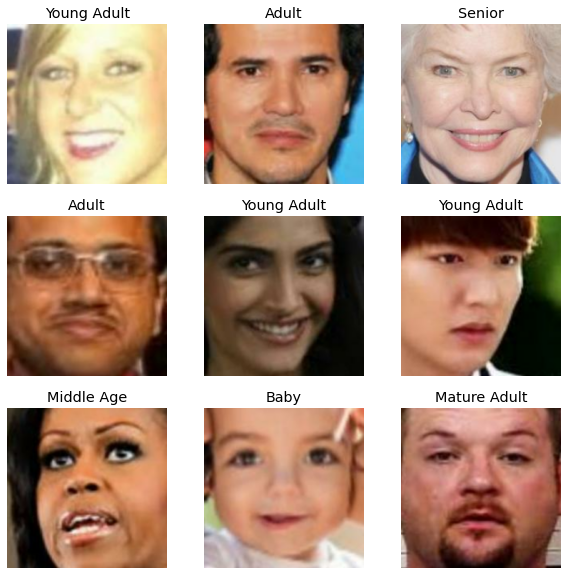

In [31]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i, j in zip(range(9), random.sample(range(32), 9)):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[j].numpy().astype("uint8"))
        plt.title(age_groups[np.argmax(labels[j])])
        plt.axis("off")
                    
# a look at some of the images in the dataset

### 1.4 Prepare Datasets for Modelling

In [32]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)

#configure dataset for performance

In [33]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
IMG_SHAPE = IMG_SIZE + (3,)

#set defaults for future use

## 2. Modelling

We will be trying out a few models to see which works best.

1. Model built from Scratch
2. Pre-trained CNN (Mobilenet)
3. Pre-trained CNN (VggFace)

### 2.1 Model built from scratch

Here we will build and train a model from scratch, including the Convolutional Neural Network(CNN) and fully-connected Classification Network.

#### 2.1.1 Build Model

In [34]:
model_new = keras.Sequential([
    layers.InputLayer(input_shape = (224, 224, 3)),
    layers.Conv2D(64, kernel_size = 3, activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(128, kernel_size = 3, activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(256, kernel_size = 3, activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(256, kernel_size = 3, activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.25),
    layers.Dense(units = 128, activation = 'relu'),
    layers.Dropout(0.25),  
    layers.Dense(units = 32, activation = 'relu'),
    layers.Dropout(0.25),
    layers.Dense(units = 10, activation = 'softmax')
])

In [35]:
model_new.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 128)     73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 256)       295168    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 256)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 256)       5

In [36]:
model_new.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
              loss = tf.keras.losses.CategoricalCrossentropy(), 
              metrics = ['accuracy'])

#### 2.1.2 Model Training

In [37]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=5,
    min_delta=0.001,
    restore_best_weights=True)

In [38]:
history = model_new.fit(train_dataset,
                    epochs=20,
                    batch_size = 32,
                    validation_data=validation_dataset,
                    callbacks=[early_stopping])

Epoch 1/20
314/314 [==============================] - 41s 106ms/step - loss: 3.2244 - accuracy: 0.1717 - val_loss: 2.1511 - val_accuracy: 0.2001
Epoch 2/20
314/314 [==============================] - 33s 106ms/step - loss: 2.1777 - accuracy: 0.2026 - val_loss: 2.1475 - val_accuracy: 0.1989
Epoch 3/20
314/314 [==============================] - 33s 105ms/step - loss: 2.1578 - accuracy: 0.1944 - val_loss: 2.0966 - val_accuracy: 0.2195
Epoch 4/20
314/314 [==============================] - 33s 105ms/step - loss: 2.1100 - accuracy: 0.2055 - val_loss: 2.0079 - val_accuracy: 0.2507
Epoch 5/20
314/314 [==============================] - 33s 106ms/step - loss: 2.0555 - accuracy: 0.2279 - val_loss: 2.0993 - val_accuracy: 0.2159
Epoch 6/20
314/314 [==============================] - 33s 106ms/step - loss: 2.0497 - accuracy: 0.2340 - val_loss: 1.9293 - val_accuracy: 0.2689
Epoch 7/20
314/314 [==============================] - 33s 106ms/step - loss: 1.9559 - accuracy: 0.2616 - val_loss: 1.8970 - val_ac

#### 2.1.3 Model Evaluation

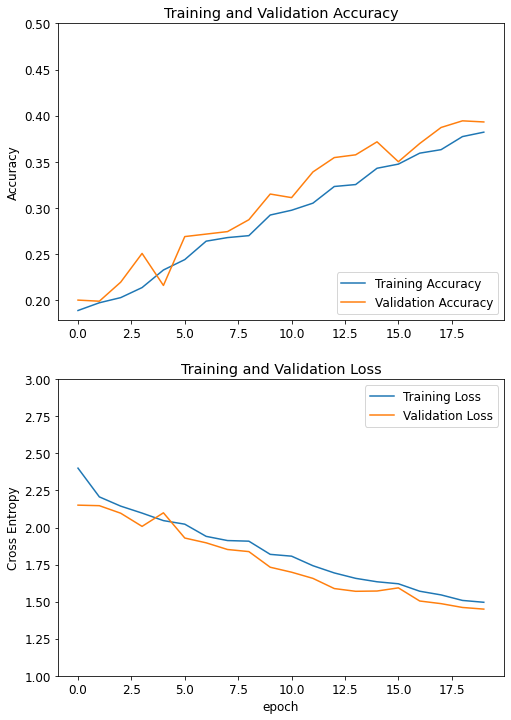

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 12))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),0.5])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([1,3])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [40]:
loss, accuracy = model_new.evaluate(validation_dataset)

105/105 [==============================] - 4s 40ms/step - loss: 1.4498 - accuracy: 0.3932


In [41]:
print("The accuracy score for this model is " + str(round(accuracy * 100)) + "%.")

The accuracy score for this model is 39%.


**Evaluation**

As we can see, this model is able to train quite quickly, but we are not able to get a very good score from it. 

Transfer learning is a good way to build on the work of others, and we will carry it out next

### 2.2 Pre-trained Model (MobileNet V2)

Here we will create a model by using a Pre-trained Convolutional Neural Netowork (CNN). 

We will first create the base model from the MobileNet V2 model developed at Google. 

This is a model that was pre-trained on the ImageNet dataset, an extensive dataset consisting of 1 400 000 images and 1000 classes. While the model is trained to classify different objects like Jackfruit and Syringe, we can use just the CNN as a generic "feature extractor".

We will then attach a Classification "Head" on top of the CNN, which will then figure out predictions based on our specific Dataset.

A useful way to think about this process is from these two images:   

![CNN](Data/Images/CNN.png)    

![Transfer Learning](Data/Images/Transfer-Learning.png)

*Credits to [Kaggle](https://www.kaggle.com/ryanholbrook/the-convolutional-classifier) for the two images*

#### 2.2.1 Initialise Pre-trained Base

In [42]:
base_mobilenet = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet', pooling = 'max')

9412608/9406464 [==============================] - 0s 0us/step


In [43]:
base_mobilenet.trainable = False

#we freeze the training for the CNN layers

In [44]:
base_mobilenet.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [46]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_mobilenet(image_batch)
print(image_batch.shape)
print(feature_batch.shape)

(32, 224, 224, 3)
(32, 1280)


In [47]:
# the convolutional layer will change each 224 X 224 X 3 image 
# into a 7 X 7 X 1280 'block' of features
# a global average layer is then applied to the 7 X 7 spatial dimension to give a set of 1280 features

#### 2.2.2 Build Model

We will build the model with the following:

1. Preprocessing Layer
2. Base Convolutional Layer (Pre-Trained)
4. Hidden Layers
5. Prediction (Output) layer

In [48]:
preprocess_mb = tf.keras.applications.mobilenet_v2.preprocess_input

In [49]:
prediction_layer = keras.Sequential([
    layers.Dropout(0.25),
    layers.Dense(units = 256, activation = 'relu'),
    layers.Dropout(0.25),  
    layers.Dense(units = 64, activation = 'relu'),
    layers.Dropout(0.25),
    layers.Dense(units = 10, activation = 'softmax')                          
])

In [50]:
inputs = tf.keras.Input(shape=(224, 224, 3))

x = preprocess_mb(inputs)
x = base_mobilenet(x)
outputs = prediction_layer(x)

model_mobilenet = tf.keras.Model(inputs, outputs)

In [51]:
base_learning_rate = 0.0001
model_mobilenet.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [52]:
model_mobilenet.summary()

#most of the parameters are not trainable.
#this is because the CNN "base" has been frozen

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 1280)              2257984   
_________________________________________________________________
sequential_1 (Sequential)    (None, 10)                345034    
Total params: 2,603,018
Trainable params: 345,034
Non-trainable params: 2,257,984
_________________________________________________________________


#### 2.2.3 Initial Model Training

In [53]:
initial_epochs = 5

In [54]:
history = model_mobilenet.fit(train_dataset,
                    batch_size = 32,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/5
314/314 [==============================] - 21s 58ms/step - loss: 3.6331 - accuracy: 0.1361 - val_loss: 2.0307 - val_accuracy: 0.2093
Epoch 2/5
314/314 [==============================] - 17s 55ms/step - loss: 2.1533 - accuracy: 0.2091 - val_loss: 1.8876 - val_accuracy: 0.2540
Epoch 3/5
314/314 [==============================] - 17s 55ms/step - loss: 2.0158 - accuracy: 0.2276 - val_loss: 1.8014 - val_accuracy: 0.3010
Epoch 4/5
314/314 [==============================] - 17s 54ms/step - loss: 1.9394 - accuracy: 0.2638 - val_loss: 1.7159 - val_accuracy: 0.3130
Epoch 5/5
314/314 [==============================] - 17s 55ms/step - loss: 1.8599 - accuracy: 0.2804 - val_loss: 1.6724 - val_accuracy: 0.3288


The Initial training is done with the entire CNN base frozen. This helps our model achieve a 'base' understanding of the data as well. For further training, we will unfreeze the top few layers of the CNN, so that our model can better understand the relationships and correlations within our specific dataset.

#### 2.2.4 Additional Model Training

In [55]:
len(base_mobilenet.layers)

155

In [56]:
base_mobilenet.trainable = True

In [57]:
# Fine-tune from this layer onwards
fine_tune_at = 120

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_mobilenet.layers[:fine_tune_at]:
    layer.trainable =  False

In [58]:
model_mobilenet.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(lr=base_learning_rate/5),
              metrics=['accuracy'])

#learning rate is reduced to prevent overfitting

In [59]:
model_mobilenet.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 1280)              2257984   
_________________________________________________________________
sequential_1 (Sequential)    (None, 10)                345034    
Total params: 2,603,018
Trainable params: 1,969,930
Non-trainable params: 633,088
_________________________________________________________________


**Increase in Trainable Parameters**

Earlier we had un-frozen the top 35 layers (out of 155 layers) of our CNN Base.   
This allows the model to better extract specific features of the images in our dataset.
Recall that the Pre-trained Mobilenet Model was trained to classify different objects like fruits and vehicles, etc. By re-training the top few layers of the CNN, we should achieve better results.

We should note that it is not necessary, and can in fact be detrimental to unfreeze too many layers. The first few layers of a CNN does **generic** feature extraction, and those have already been trained well and can be applied to any image. We only need to train the top few layers of the CNN for it to better adapt to the **specific** features of our dataset.

In [60]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=3,
    min_delta=0.001,
    restore_best_weights=True)

In [61]:
fine_tune_epochs = 20
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model_mobilenet.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset,
                         callbacks = [early_stopping])

Epoch 5/25
314/314 [==============================] - 22s 63ms/step - loss: 2.1018 - accuracy: 0.2235 - val_loss: 1.6780 - val_accuracy: 0.3384
Epoch 6/25
314/314 [==============================] - 19s 61ms/step - loss: 1.8446 - accuracy: 0.2896 - val_loss: 1.5813 - val_accuracy: 0.3600
Epoch 7/25
314/314 [==============================] - 19s 61ms/step - loss: 1.7328 - accuracy: 0.3278 - val_loss: 1.5442 - val_accuracy: 0.3717
Epoch 8/25
314/314 [==============================] - 19s 61ms/step - loss: 1.6536 - accuracy: 0.3416 - val_loss: 1.5150 - val_accuracy: 0.3816
Epoch 9/25
314/314 [==============================] - 19s 61ms/step - loss: 1.6058 - accuracy: 0.3515 - val_loss: 1.4839 - val_accuracy: 0.3851
Epoch 10/25
314/314 [==============================] - 19s 61ms/step - loss: 1.5345 - accuracy: 0.3857 - val_loss: 1.4599 - val_accuracy: 0.3908
Epoch 11/25
314/314 [==============================] - 19s 61ms/step - loss: 1.4773 - accuracy: 0.3954 - val_loss: 1.4516 - val_accurac

#### 2.2.5 Model Evaluation

In [62]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


In [63]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

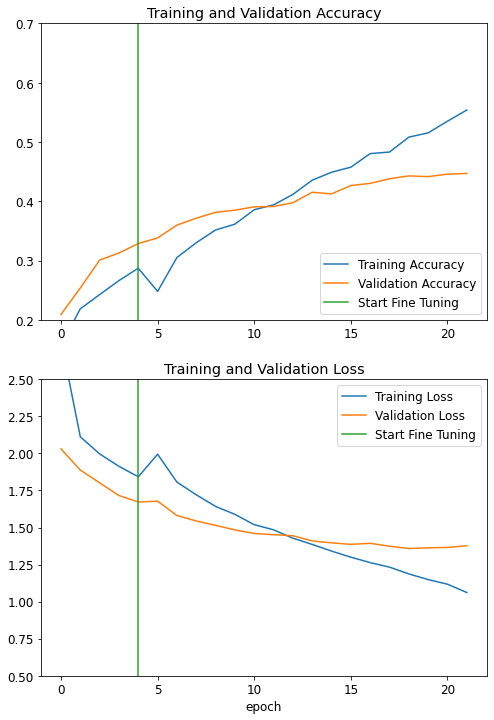

In [67]:
plt.figure(figsize=(8, 12))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.2, 0.7])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0.5, 2.5])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [68]:
loss, accuracy = model_mobilenet.evaluate(validation_dataset)

105/105 [==============================] - 4s 42ms/step - loss: 1.3584 - accuracy: 0.4429


In [69]:
print("The accuracy score for this model is " + str(round(accuracy * 100)) + "%.")

The accuracy score for this model is 44%.


**Evaluation**

Notice that we have attained a much better score by using a Pre-Trained Convolutional base. However, 44% is not yet satisfactory. We will next try and use a better Convolutional base that could be more suited to the task at hand.

### 2.3 Pre-trained Model (VggFace)

The [VggFace](https://www.robots.ox.ac.uk/~vgg/software/vgg_face/) model is trained for Facial Recognition; it is able to identify different faces with 92.8% to 99.1% accuracy.

While our task of age-detection is differen from face recognition, we can still use the Convolutional Base of this model, as it has been trained to extract facial features. This will hopefully allow us to gain a higher accuracy for our model.

#### 2.3.1 Initialise Pre-Trained Base

In [70]:
!pip install git+https://github.com/rcmalli/keras-vggface.git

  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-rp82372d
  Running command git clone -q https://github.com/rcmalli/keras-vggface.git /tmp/pip-req-build-rp82372d
  Created wheel for keras-vggface: filename=keras_vggface-0.6-cp36-none-any.whl size=8310 sha256=655975194c12fd8b5c112f45b12f8b66d5d480071cefd628148a289509267477
  Stored in directory: /tmp/pip-ephem-wheel-cache-s_yxv4_n/wheels/36/07/46/06c25ce8e9cd396dabe151ea1d8a2bc28dafcb11321c1f3a6d
Successfully built keras-vggface


In [71]:
!pip install keras-applications

     |████████████████████████████████| 51kB 4.4MB/s 


In [72]:
from keras_vggface.vggface import VGGFace
base_vgg = VGGFace(include_top=False, input_shape=(224, 224, 3), pooling = 'avg')

58916864/58909280 [==============================] - 2s 0us/step


In [73]:
base_vgg.trainable = False

In [74]:
len(base_vgg.layers)

20

In [75]:
base_vgg.summary()

Model: "vggface_vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)     

In [76]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_vgg(image_batch)
print(image_batch.shape)
print(feature_batch.shape)

(32, 224, 224, 3)
(32, 512)


In [77]:
# the convolutional layer will change each 224 X 224 X 3 image 
# into a 7 X 7 X 512 'block' of features
# a global average layer is then applied to the 7 X 7 spatial dimension to give a set of 512 features

#### 2.3.2 Build Model

We will build the model with the following:

1. Base Convolutional Layer
2. Hidden Layers
3. Prediction (Output) layer

In [78]:
x = base_vgg.output

# let's add a few fully-connected layer
x = Dropout(0.25)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.25)(x)

# prediction layer
predictions = Dense(10, activation='softmax')(x)

# this is the model we will train
model_vgg = Model(inputs=base_vgg.input, outputs=predictions)
len(model_vgg.layers)

26

In [79]:
base_learning_rate = 0.0001
model_vgg.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss = tf.keras.losses.CategoricalCrossentropy(), 
              metrics = ['accuracy'])

In [80]:
model_vgg.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0   

#### 2.3.3 Initial Model Training

We first train the model for only 5 epochs. Similar to our Mobilenet Model, in this initial phase of modelling, we left all the layers of the Convolutional neural network untouched (ie, the weights are not updated).

In [81]:
initial_epochs = 5

In [82]:
history = model_vgg.fit(train_dataset,
                    epochs=initial_epochs,
                    batch_size = 32,
                    validation_data=validation_dataset)

Epoch 1/5
314/314 [==============================] - 58s 177ms/step - loss: 7.2475 - accuracy: 0.1416 - val_loss: 2.0147 - val_accuracy: 0.2899
Epoch 2/5
314/314 [==============================] - 53s 170ms/step - loss: 2.4748 - accuracy: 0.2146 - val_loss: 1.9933 - val_accuracy: 0.2986
Epoch 3/5
314/314 [==============================] - 53s 170ms/step - loss: 2.1688 - accuracy: 0.2397 - val_loss: 1.8590 - val_accuracy: 0.3243
Epoch 4/5
314/314 [==============================] - 53s 170ms/step - loss: 2.0667 - accuracy: 0.2611 - val_loss: 1.7116 - val_accuracy: 0.3324
Epoch 5/5
314/314 [==============================] - 53s 170ms/step - loss: 1.9224 - accuracy: 0.2883 - val_loss: 1.5810 - val_accuracy: 0.3684


#### 2.3.4 Additional Model Training

As we had done previously, here we fine tune the model by 'unfreezing' the top layers of the convolutional network. While the CNN is already good at extracting facial features, this will still allow the model to better extract specific features based on this dataset.

In [83]:
base_vgg.trainable = True

In [84]:
len(base_vgg.layers)

20

In [85]:
# Fine-tune from this layer onwards
fine_tune_at = 15

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_vgg.layers[:fine_tune_at]:
    layer.trainable =  False

In [86]:
model_vgg.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(lr=base_learning_rate/5),
              metrics=['accuracy'])

#learning rate is reduced to prevent overfitting

In [87]:
model_vgg.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0   

In [88]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=5,
    min_delta=0.001,
    restore_best_weights=True)

In [89]:
fine_tune_epochs = 25
total_epochs =  initial_epochs + fine_tune_epochs

history_fine_tune = model_vgg.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset,
                         callbacks=[early_stopping])

Epoch 5/30
314/314 [==============================] - 61s 191ms/step - loss: 1.7503 - accuracy: 0.3259 - val_loss: 1.3796 - val_accuracy: 0.4310
Epoch 6/30
314/314 [==============================] - 60s 190ms/step - loss: 1.5358 - accuracy: 0.3814 - val_loss: 1.3012 - val_accuracy: 0.4798
Epoch 7/30
314/314 [==============================] - 60s 190ms/step - loss: 1.4291 - accuracy: 0.4195 - val_loss: 1.2385 - val_accuracy: 0.5025
Epoch 8/30
314/314 [==============================] - 60s 191ms/step - loss: 1.3645 - accuracy: 0.4302 - val_loss: 1.2154 - val_accuracy: 0.4963
Epoch 9/30
314/314 [==============================] - 60s 190ms/step - loss: 1.2949 - accuracy: 0.4620 - val_loss: 1.1736 - val_accuracy: 0.5133
Epoch 10/30
314/314 [==============================] - 60s 190ms/step - loss: 1.2416 - accuracy: 0.4839 - val_loss: 1.1482 - val_accuracy: 0.5169
Epoch 11/30
314/314 [==============================] - 60s 190ms/step - loss: 1.1736 - accuracy: 0.5047 - val_loss: 1.1519 - val_

#### 2.3.5 Model evaluation

In [90]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [91]:
acc += history_fine_tune.history['accuracy']
val_acc += history_fine_tune.history['val_accuracy']

loss += history_fine_tune.history['loss']
val_loss += history_fine_tune.history['val_loss']

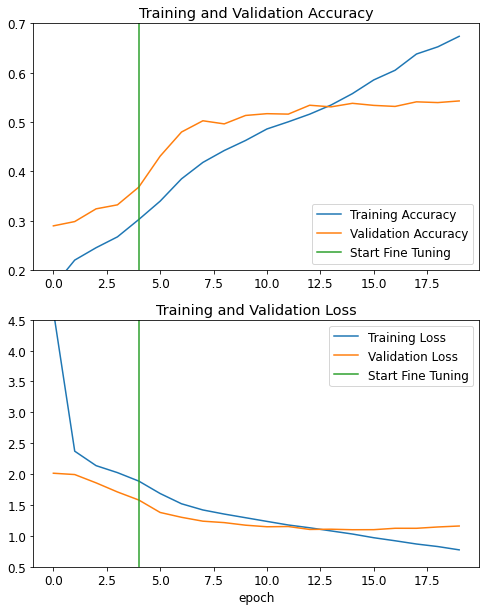

In [92]:
plt.figure(figsize=(8, 10))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.2, 0.7])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0.5, 4.5])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [93]:
loss, accuracy = model_vgg.evaluate(validation_dataset)

105/105 [==============================] - 13s 127ms/step - loss: 1.1002 - accuracy: 0.5379


In [94]:
print("The accuracy score for this model is " + str(round(accuracy * 100)) + "%.")

The accuracy score for this model is 54%.


**Evaluation**

Of the three models we have used, the one with VggFace as the Base CNN performs the best. This is expected as VggFace is specifically trained for facial features.

## 3. Model Performance

### 3.1 Predictions on Validation Dataset

In [96]:
model = model_vgg  #best performing model

In [97]:
val_preds = model.predict(validation_dataset)

In [98]:
val_predictions = [np.argmax(p) for p in val_preds]

In [99]:
X_test['Pred Label'] = val_predictions

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [100]:
X_test.head()

,age,ethnicity,gender,age group,Filename,age label,Pred Label
8711,36,0,1,Mature Adult,36_1_0_20170117135851878.jpg.chip.jpg,7,6
13316,9,0,1,Adolescent,9_1_0_20170117180006484.jpg.chip.jpg,3,2
3710,22,1,1,Young Adult,22_1_1_20170103180755073.jpg.chip.jpg,5,6
293,1,3,0,Baby,1_0_3_20161220144425181.jpg.chip.jpg,0,0
4082,23,1,0,Young Adult,23_0_1_20170114033506795.jpg.chip.jpg,5,5


In [101]:
X_test['Difference'] = X_test['Pred Label'] - X_test['age label']
X_test['Difference'] = X_test['Difference'].apply(abs)
X_test.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,age,ethnicity,gender,age group,Filename,age label,Pred Label,Difference
8711,36,0,1,Mature Adult,36_1_0_20170117135851878.jpg.chip.jpg,7,6,1
13316,9,0,1,Adolescent,9_1_0_20170117180006484.jpg.chip.jpg,3,2,1
3710,22,1,1,Young Adult,22_1_1_20170103180755073.jpg.chip.jpg,5,6,1
293,1,3,0,Baby,1_0_3_20161220144425181.jpg.chip.jpg,0,0,0
4082,23,1,0,Young Adult,23_0_1_20170114033506795.jpg.chip.jpg,5,5,0


In [109]:
X_test.shape

(3339, 8)

In [108]:
misclass_count = X_test['Difference'].value_counts().to_frame(name = 'Count')
misclass_count.reset_index(inplace = True)
misclass_count.rename(columns = {'index' : 'Misclass Difference'}, inplace = True)
misclass_count.sort_values(by = ['Misclass Difference'], inplace = True)
misclass_count

,Misclass Difference,Count
0,0,1796
1,1,1325
2,2,195
3,3,16
6,4,2
7,5,1
5,6,2
4,7,2


**Misclassfication**

The table above shows the number of images that were misclassified, and it also shows the difference between the predicted label and the actual label.

We can see that, out of 3339 images, 1796 images were identified accurately. There were 1325 images that were misclassified by only one class.

In [103]:
print("The exact accuracy for the model is " + str(round(accuracy_score(y_test, val_predictions) * 100)) + "%")

The exact accuracy for the model is 54%


In [104]:
print("The accuracy for the model up to 1-class difference is " + 
      str(round((misclass_count.iloc[0, 0] + misclass_count.iloc[1, 0]) / X_test.shape[0] * 100)) + "%")

The accuracy for the model up to 1-class difference is 93%


In [105]:
print("The Mean Absolute Error for this model is " + str(mean_absolute_error(y_test, val_predictions)))

The Mean Absolute Error for this model is 0.5396825396825397


### 3.2 Evaluating Misclassified Images

In [110]:
X_test['Difference'].value_counts()

0    1796
1    1325
2     195
3      16
7       2
6       2
4       2
5       1
Name: Difference, dtype: int64

We can see that most of the misclassified data is off by only one age-group. There are also 5.8% of images that were classified by 2 age-groups.

There are a few images that were misclassified by more than 2 age-groups, but since they form less than 1% of the images, they can be considered as outliers.

We will take a closer look at those who were misclassified by only 1 or 2 age-groups.

In [111]:
misclass_df = X_test[X_test['Difference'].isin([1, 2])]

In [112]:
misclass_df.head()

,age,ethnicity,gender,age group,Filename,age label,Pred Label,Difference
8711,36,0,1,Mature Adult,36_1_0_20170117135851878.jpg.chip.jpg,7,6,1
13316,9,0,1,Adolescent,9_1_0_20170117180006484.jpg.chip.jpg,3,2,1
3710,22,1,1,Young Adult,22_1_1_20170103180755073.jpg.chip.jpg,5,6,1
1077,10,0,0,Adolescent,10_0_0_20170110225243501.jpg.chip.jpg,3,5,2
7130,3,0,1,Toddler,3_1_0_20170109191815204.jpg.chip.jpg,1,0,1


In [113]:
misclass_df['Difference'].value_counts()

1    1325
2     195
Name: Difference, dtype: int64

In [114]:
misclass_df.reset_index(drop = True, inplace = True)

In [118]:
misclass_df.head()

,age,ethnicity,gender,age group,Filename,age label,Pred Label,Difference
0,36,0,1,Mature Adult,36_1_0_20170117135851878.jpg.chip.jpg,7,6,1
1,9,0,1,Adolescent,9_1_0_20170117180006484.jpg.chip.jpg,3,2,1
2,22,1,1,Young Adult,22_1_1_20170103180755073.jpg.chip.jpg,5,6,1
3,10,0,0,Adolescent,10_0_0_20170110225243501.jpg.chip.jpg,3,5,2
4,3,0,1,Toddler,3_1_0_20170109191815204.jpg.chip.jpg,1,0,1


In [153]:
misclass_agegroup = misclass_df['age group'].value_counts(normalize = True).to_frame(name = 'Misclass Age %')
misclass_agegroup.sort_index(inplace = True)

In [154]:
dataset_agegroup = face_data['age group'].value_counts(normalize = True).to_frame(name = 'Dataset Age %')
dataset_agegroup.sort_index(inplace = True)

In [155]:
age_proportion = dataset_agegroup.join(misclass_agegroup)
age_proportion

,Dataset Age %,Misclass Age %
Adolescent,0.033543,0.055921
Adult,0.196466,0.196711
Baby,0.080338,0.009211
Child,0.067535,0.058553
Mature Adult,0.151767,0.193421
Middle Age,0.103399,0.144079
Senior,0.072701,0.042763
Teenager,0.056229,0.088816
Toddler,0.057727,0.086184
Young Adult,0.180294,0.124342


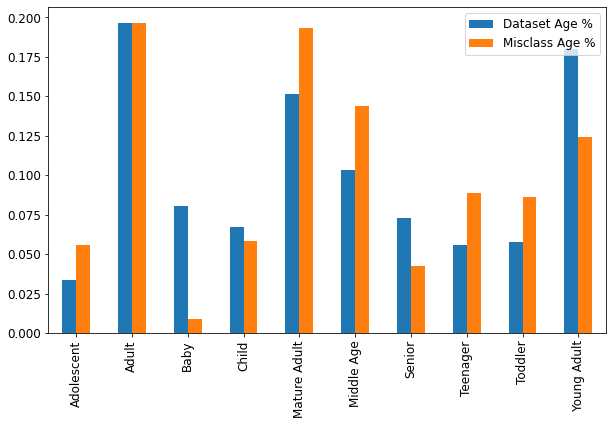

In [156]:
age_proportion.plot.bar(figsize = (10, 6))

The misclassification does not seem to be affected by the imbalance in the age-groups. Those age-groups with higher proportions in the dataset also received higher proportions of misclassified data; similarly for those with lower proportion.

In [157]:
misclass_race = misclass_df['ethnicity'].value_counts(normalize = True).to_frame(name = 'Misclass Race %')
misclass_race.sort_index(inplace = True)

In [158]:
dataset_race = face_data['ethnicity'].value_counts(normalize = True).to_frame(name = 'Dataset Race %')
dataset_race.sort_index(inplace = True)

In [159]:
race_proportion = dataset_race.join(misclass_race)
race_proportion

,Dataset Race %,Misclass Race %
0,0.324498,0.311842
1,0.181566,0.200000
2,0.185385,0.158553
3,0.197290,0.217763
4,0.111261,0.111842


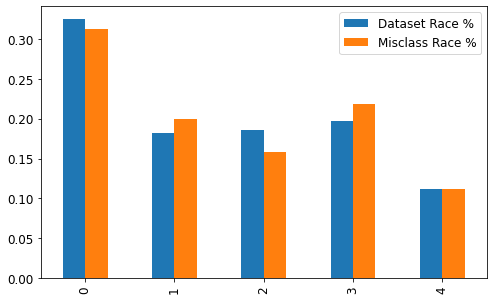

In [161]:
race_proportion.plot.bar(figsize = (8, 5))

Similarly, the misclassfications also do not seem to be affected by racial imbalance in the dataset.

In [123]:
misclass_df.head(3)

,age,ethnicity,gender,age group,Filename,age label,Pred Label,Difference
0,36,0,1,Mature Adult,36_1_0_20170117135851878.jpg.chip.jpg,7,6,1
1,9,0,1,Adolescent,9_1_0_20170117180006484.jpg.chip.jpg,3,2,1
2,22,1,1,Young Adult,22_1_1_20170103180755073.jpg.chip.jpg,5,6,1


In [124]:
index = set(misclass_df.index)
len(index)

1520

In [125]:
data_dir

PosixPath('/root/.keras/datasets/UTKFace')

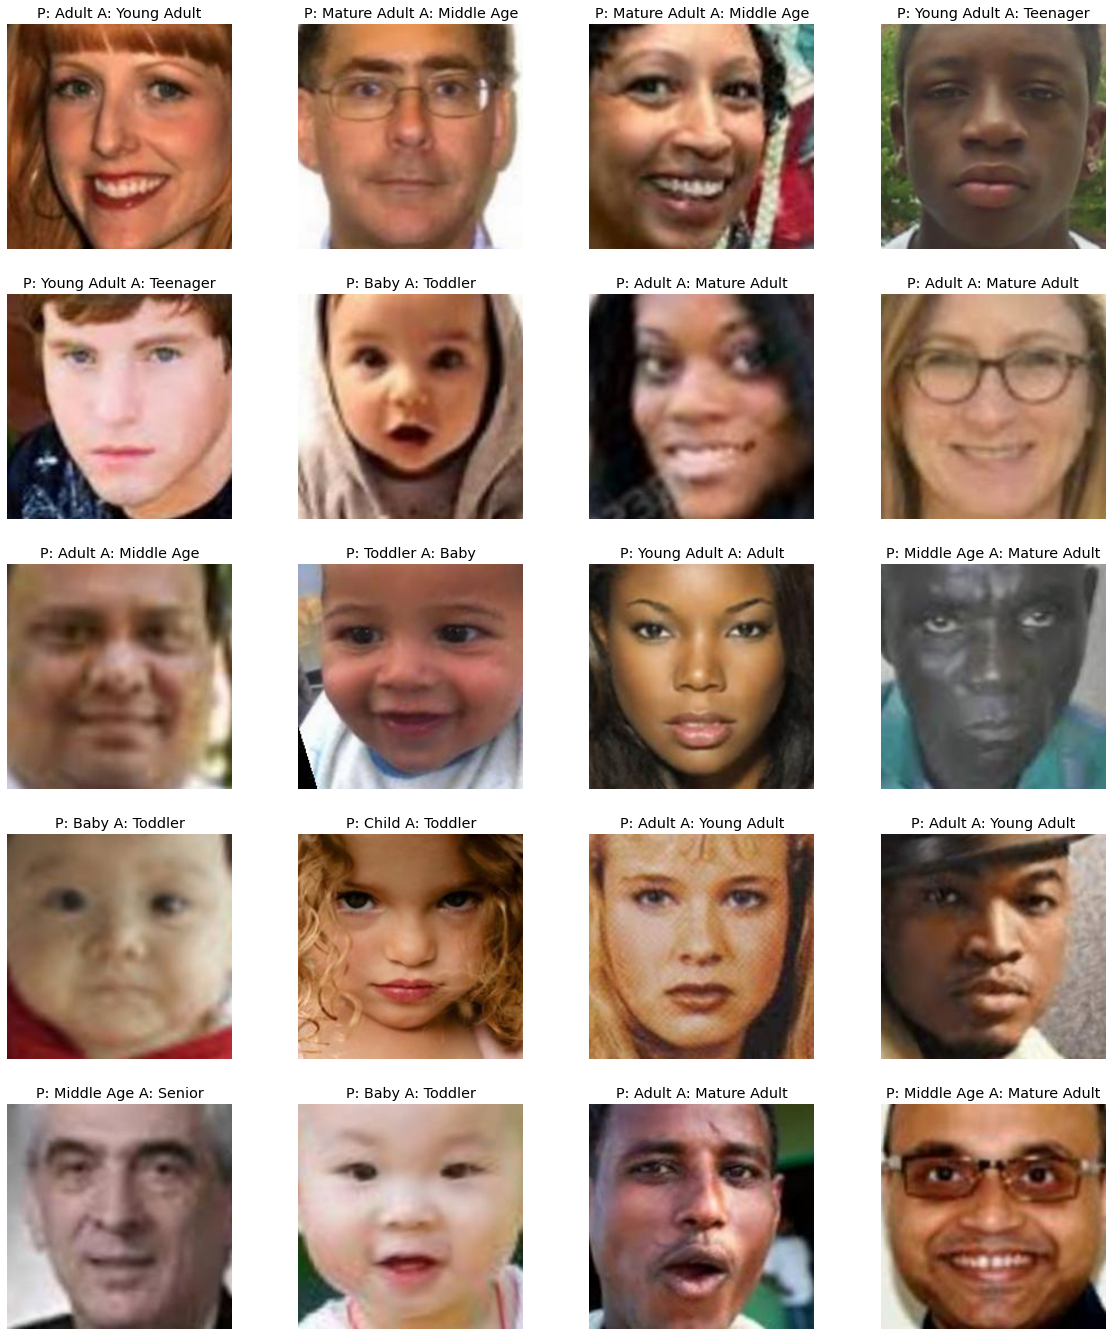

In [129]:
plt.figure(figsize=(20, 24))

for i, j in zip(range(20), random.sample(index, 20)):
    
    ax = plt.subplot(5, 4, i + 1)
    
    image_dir = str(data_dir)+ '/' + misclass_df['Filename'][j]

    image = Image.open(image_dir).resize((224, 224))
    prediction = misclass_df['Pred Label'][j]
    age_label = misclass_df['age group'][j]
    
    plt.imshow(image)
    plt.title("P: " + age_groups[prediction] + " A: " + age_label)
    plt.axis("off")

The above code cell generates a random sample of all the misclassified images every time the it is run, so feel free to run the code cell a few times to look at different misclassified images.

A few trends that can be seen are:

1. Blur image quality. While all images are 200 X 200 pixels, there are some of them with really poor resolution and quality. This seems to be the biggest factor in misclassification

2. Makeup on women. Depending on the age-group, women and girls with makeup on tend to be classified into a higher age-group.


3. Toddlers and babies. Since babies are classified as 1 year olds only, while toddlers are classified as 2-3 years old. Due to the short gap between the two classes, we do see a lot of misclassification happening even on high-quality images.

### 3.3 Save trained model

In [130]:
!pip install -q pyyaml h5py

In [131]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [132]:
filepath

'/content/drive/My Drive/DSI Projects/Capstone Project/'

In [133]:
model.save(filepath + 'Data/saved_model/final_model.h5')

## 4. Conclusions & Recommendations

### 4.1 Conclusions

The model can be considered a moderate success as it is able to classify 94% of images up to 1-class accuracy. This is expected as the age groups are continuous integers, and hence images of people who are near the boundaries of the age-ranges will tend to be misclassified.

However, if we look at the exact accuracy score of 54%, there is definitely room for improvement.

### 4.2 Future Improvements

1. **Fine-tune model further**. We can try varying the number of layers we unfroze in the CNN-base to better adapt the model to the dataset. There are also other Pre-Trained Convolutional Networks we could try and adapt to this model.

2. **Carry out a more thorough Data Cleaning process.** As we have seen in the evaluation, there are quite a lot of photos with poor image quality. A more thorough data cleaning process could improve the data pipeline, thereby improving the model performance as well.

3. **Look for more Data.** We have found that there is quite a lot of imbalance in the dataset. We tried to reduce it by removing some images; but that means loss of data. If we could instead look for more images to increase the images that have a lower proportion, that would result in a more robust and extensive dataset.

### 4.3 What's next?

This model on its own is not quite ready for deployment. Images need to be cropped before analysis, which can be a tedious process. If we pair this model with an effective face-segmentation model, that will allow us to identify multiple faces in a single image, and give predictions to each of them.

Our model is also trained only for ages 1-74. With more data and better computing resources, this model can be expanded to cover age ranges up to 99 years old.